CIFAR10 dataset split into neg/pos and trained using normal CNN without augmentation. With ds resampling (see https://www.tensorflow.org/guide/data#resampling). Learning well with normal CNN.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Jupyter-specific
%matplotlib inline

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

MODEL = 'cnn' 
DS_INFO = 'binary'
NUM_EPOCHS = 10
BATCH_SIZE = 64
IMG_HEIGHT = 32
IMG_WIDTH = 32

NUM_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

# epoch*batch_size*img_size
model_name = '{}x{}x{}_{}_{}'.format(NUM_EPOCHS, BATCH_SIZE, IMG_WIDTH, DS_INFO, MODEL)

In [3]:
def print_class_info(directories_ex_outcast, class_names, neg, pos):
    # Extract and print info about the class split 
    
    for i, class_ in enumerate([neg,pos]):
        print ("{} class names:".format(class_names[i]))
        for cl in class_:
            print ("{}- {}".format(" "*8, cl))
    
    neg_count = pos_count = 0
    for dir_name in directories_ex_outcast:
        # Number of samples in 'class_name' folder
        class_samples = len(list(data_dir.glob(dir_name+'/*.*g')))

        if (dir_name == neg_class_name[0]):
            neg_count += class_samples
        else:
            pos_count += class_samples

    print ('\nNegative samples: {0:5} | {1:5.2f}%'.format(neg_count, neg_count/DATASET_SIZE*100))
    print ('Positive samples: {0:5} | {1:5.2f}%'.format(pos_count, pos_count/DATASET_SIZE*100))
    # Print number of images in dataset (excluded samples in outcast)
    print ('\nTotal number of images:', DATASET_SIZE)

In [4]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/train/')
outcast = 'None'

DATASET_SIZE = len(list(data_dir.glob('[!'+str(outcast)+']*/*.*g')))
directories = np.array([item.name for item in data_dir.glob('*') if item.name != 'metadata.json'])
print ("Directories: ", directories)

# Remove outcasts
directories_ex_outcast = np.delete(directories, np.where(outcast == directories))
print ("\nRemoved outcast: ", outcast, "\n")

class_names = np.array(['Negative','Positive'])
NUM_CLASSES = len(class_names)
neg_class_name = ['ship'] # 'normal'-class
pos_class_names = np.delete(directories_ex_outcast, np.where(neg_class_name == directories_ex_outcast))

print_class_info(directories_ex_outcast, class_names, neg_class_name, pos_class_names)

Directories:  ['cat' 'airplane' 'deer' 'automobile' 'ship' 'horse' 'truck' 'dog' 'bird'
 'frog']

Removed outcast:  None 

Negative class names:
        - ship
Positive class names:
        - cat
        - airplane
        - deer
        - automobile
        - horse
        - truck
        - dog
        - bird
        - frog

Negative samples:  5000 | 10.00%
Positive samples: 45000 | 90.00%

Total number of images: 50000


Set up pipeline for loading images from given list of paths, using `tf.data.Dataset`

In [5]:
# Create a dataset of the file paths | data_dir/*/* but subract class
list_ds = tf.data.Dataset.list_files(str(data_dir/'[!')+str(outcast+']*/*'))

In [6]:
# convert a file path to an `image_data, label` pair

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    bc = parts[-2] == pos_class_names
    nz_cnt = tf.math.count_nonzero(bc)
    if (nz_cnt > 0):
        return tf.constant(1, tf.int32)
    return tf.constant(0, tf.int32)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Showing an example image/label pair

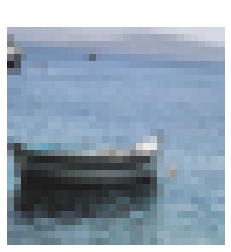

In [7]:
def show_image(img):
    if (isinstance(img, tf.data.Dataset)):
        for image, label in img:
            plt.figure(frameon=False, facecolor='white')
            title = class_names[label.numpy()]+" ["+str(label.numpy())+"]"
            plt.title(title, fontdict={'color':'white','size':20})
            plt.imshow(image.numpy())
            plt.axis('off')
    else:
        plt.figure(frameon=False, facecolor='white')
        plt.title("None", fontdict={'color':'white','size':20})
        plt.imshow(img)
        plt.axis('off')

# Take one image
show_image(labeled_ds.take(1))

### Resampling the dataset to a 50/50 distribution
https://www.tensorflow.org/guide/data#resampling

In [8]:
# Make large batches to be certain a good amount of minority class makes it in
labeled_ds = labeled_ds.batch(1024)

In [9]:
def count(counts, batch):
        images, labels = batch
        
        class_1 = labels == 1
        class_1 = tf.cast(class_1, tf.int32)

        class_0 = labels == 0
        class_0 = tf.cast(class_0, tf.int32)

        counts['class_0'] += tf.reduce_sum(class_0)
        counts['class_1'] += tf.reduce_sum(class_1)

        return counts

In [10]:
counts = labeled_ds.take(10).reduce(
        initial_state={'class_0': 0, 'class_1': 0},
        reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

counts_sum = counts.sum()
assert counts_sum != 0, "Can't divide by zero"

fractions = counts/counts_sum
print("Fractions: ", fractions)
print("Counts: ", counts)

Fractions:  [0.09902344 0.90097654]
Counts:  [1014. 9226.]


In [11]:
negative_ds = labeled_ds.unbatch().filter(lambda image, label: label==0).repeat()
positive_ds = labeled_ds.unbatch().filter(lambda image, label: label==1).repeat()

In [12]:
balanced_ds = tf.data.experimental.sample_from_datasets(
    [negative_ds, positive_ds], [0.5, 0.5]).batch(10)

In [13]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[0 0 1 1 1 1 0 1 1 1]
[1 1 1 0 0 1 0 0 0 0]
[1 1 0 1 1 0 0 0 0 1]
[1 1 0 0 0 0 0 1 0 0]
[0 1 0 0 1 1 1 0 0 1]
[1 1 1 0 1 0 0 0 0 0]
[0 1 1 1 1 1 0 1 0 0]
[0 1 1 0 0 1 1 0 1 0]
[1 1 1 1 0 1 1 0 1 1]
[0 1 1 1 0 0 0 0 0 1]


In [14]:
# Verify that it has been resampled
counts = balanced_ds.take(30).reduce(
        initial_state={'class_0': 0, 'class_1': 0},
        reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

print(counts/counts.sum())

[0.54 0.46]


### Splitting into training, test and validation data

In [15]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

shuffled_ds = balanced_ds.unbatch()#.shuffle(buffer_size=10000)

train_ds = shuffled_ds.take(train_size)
test_ds = shuffled_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [16]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=3000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create training, test and validation dataset
train_ds = prepare_for_training(train_ds, cache="./cache/{}_train.tfcache".format(IMG_WIDTH))
test_ds = prepare_for_training(test_ds, cache="./cache/{}_test.tfcache".format(IMG_WIDTH))
val_ds = prepare_for_training(val_ds, cache="./cache/{}_val.tfcache".format(IMG_WIDTH))

# Training

### Normal CNN
See https://www.tensorflow.org/tutorials/images/cnn

In [17]:
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [18]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [19]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

In [20]:
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(MODEL), update_freq='batch')]

In [29]:
history = cnn_model.fit(
        train_ds,
        steps_per_epoch = train_size // BATCH_SIZE,
        epochs = NUM_EPOCHS,
        validation_data = test_ds,
        validation_steps = test_size // BATCH_SIZE,
        validation_freq = 1,
        callbacks = callbacks)

Train for 546 steps, validate for 117 steps
Epoch 1/10
546/546 [==============================] - 5s 9ms/step - loss: 0.3102 - accuracy: 0.8739 - val_loss: 0.2321 - val_accuracy: 0.9067
Epoch 2/10
546/546 [==============================] - 3s 6ms/step - loss: 0.1782 - accuracy: 0.9287 - val_loss: 0.2566 - val_accuracy: 0.8980
Epoch 3/10
546/546 [==============================] - 3s 6ms/step - loss: 0.1252 - accuracy: 0.9522 - val_loss: 0.2175 - val_accuracy: 0.9048
Epoch 4/10
546/546 [==============================] - 3s 6ms/step - loss: 0.0939 - accuracy: 0.9657 - val_loss: 0.0916 - val_accuracy: 0.9659
Epoch 5/10
546/546 [==============================] - 3s 5ms/step - loss: 0.0686 - accuracy: 0.9745 - val_loss: 0.1455 - val_accuracy: 0.9451
Epoch 6/10
546/546 [==============================] - 3s 6ms/step - loss: 0.0570 - accuracy: 0.9792 - val_loss: 0.0833 - val_accuracy: 0.9721
Epoch 7/10
546/546 [==============================] - 3s 6ms/step - loss: 0.0415 - accuracy: 0.9857 - va

`Keras`
Save/load the model

In [30]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Validate the results

In [31]:
cnn_evaluate = cnn_model.evaluate(val_ds, verbose=2, steps=val_size//BATCH_SIZE)

117/117 - 20s - loss: 0.1093 - accuracy: 0.9682


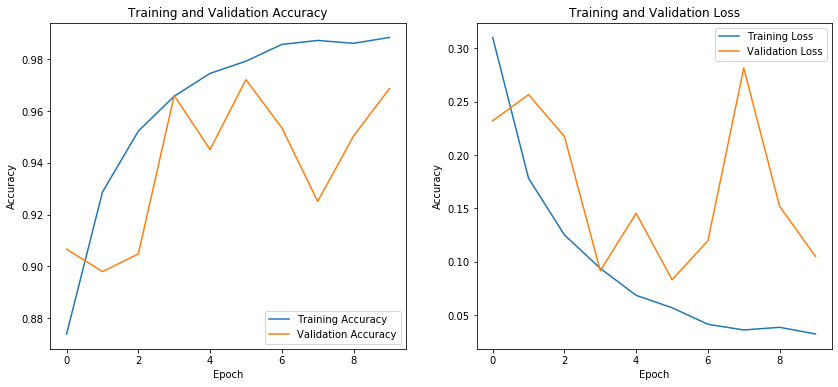

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [33]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0000 | Negative
1.0000 | Positive
Image 19 of 64


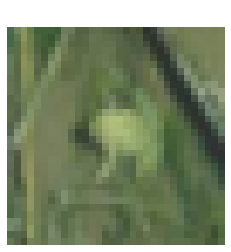

In [35]:
# Get a random image and label
rand = np.random.randint(0, BATCH_SIZE)
image = images[rand]
label = labels[rand]

# Predict one image
predictions = cnn_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} | {}".format(pred, class_names[i]))

prediction = ('Boat') if np.argmax(predictions)==0 else ('Not boat')

print ("Image {} of {}".format(rand, BATCH_SIZE))

plt.figure(frameon=False, facecolor='white');
plt.title(prediction, fontdict={'color':'white','size':20})
plt.imshow(image)
plt.axis('off');

In [36]:
# Predict one batch
predictions = cnn_model.predict(images)

print ('{:3}  {:5}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -----  ----')

for i, pred in enumerate(predictions):
    label = class_names[labels[i]][0:3]
    prediction = class_names[np.argmax(pred)][0:3]
    print ('\n{:3}  {:5}  {:5}'.format(i, label, prediction), end='')
    if (label != prediction): print ("Wrong", end='')

idx  label  pred
---  -----  ----

  0  Pos    Pos  
  1  Pos    Pos  
  2  Pos    Pos  
  3  Neg    Neg  
  4  Neg    Neg  
  5  Neg    Neg  
  6  Neg    Neg  
  7  Neg    Neg  
  8  Neg    Neg  
  9  Pos    Pos  
 10  Neg    Neg  
 11  Neg    Pos  Wrong
 12  Pos    Pos  
 13  Neg    Neg  
 14  Pos    Pos  
 15  Neg    Neg  
 16  Neg    Neg  
 17  Neg    Neg  
 18  Neg    Neg  
 19  Pos    Pos  
 20  Neg    Neg  
 21  Pos    Pos  
 22  Pos    Pos  
 23  Neg    Neg  
 24  Pos    Pos  
 25  Neg    Neg  
 26  Neg    Neg  
 27  Pos    Pos  
 28  Neg    Neg  
 29  Pos    Pos  
 30  Pos    Pos  
 31  Neg    Neg  
 32  Neg    Neg  
 33  Neg    Neg  
 34  Neg    Neg  
 35  Neg    Neg  
 36  Pos    Pos  
 37  Neg    Neg  
 38  Neg    Neg  
 39  Pos    Pos  
 40  Pos    Pos  
 41  Neg    Neg  
 42  Neg    Neg  
 43  Neg    Neg  
 44  Pos    Pos  
 45  Pos    Pos  
 46  Pos    Pos  
 47  Neg    Neg  
 48  Neg    Neg  
 49  Pos    Pos  
 50  Pos    Pos  
 51  Neg    Neg  
 52  Neg    Neg  
 53  P